In [114]:
#common code:
from scipy.stats import ttest_ind
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import re
#week 3
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
#week 4
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
#week 5
import requests
from bs4 import BeautifulSoup
import time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
#week 6
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, RandomForestRegressor
from sklearn.svm import LinearSVC, SVC, LinearSVR
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.datasets import make_classification
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier


In [115]:
train = pd.read_csv('./data/train.csv.gz')

In [116]:
train.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [117]:
train.isnull().sum() #check for null values

AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
dtype: int64

In [118]:
train.shape #check data size

(26729, 10)

Of the null values, there are too many in the 'Name' and 'OutcomeSubtype' column to drop so I'll need to do something with those. The SexuponOutcome and AgeuponOutcome nulls are only 19 rows in total out of my 26k+ so I'll be dropping them.

In [119]:
train.columns = [col.lower().replace(' ', '_') for col in train.columns] #format columns

In [120]:
train.columns

Index(['animalid', 'name', 'datetime', 'outcometype', 'outcomesubtype',
       'animaltype', 'sexuponoutcome', 'ageuponoutcome', 'breed', 'color'],
      dtype='object')

In [121]:
train.dropna(axis=0, subset=['ageuponoutcome', 'sexuponoutcome'], inplace=True)

In [122]:
train.isnull().sum()

animalid              0
name               7673
datetime              0
outcometype           0
outcomesubtype    13611
animaltype            0
sexuponoutcome        0
ageuponoutcome        0
breed                 0
color                 0
dtype: int64

In [123]:
train.shape #dropped the 19 null values from ageuponoutcome and sexuponoutcome

(26710, 10)

In [124]:
print(train['name'].value_counts().head().to_markdown())

|         |   name |
|:--------|-------:|
| Max     |    136 |
| Bella   |    135 |
| Charlie |    107 |
| Daisy   |    106 |
| Lucy    |     94 |


Many animals share the same name - we will see if this impacts their adoption likelihood at all.

In [125]:
train['name'].fillna('Unnamed', inplace=True)

In [126]:
train.isnull().sum() #fixed name nulls

animalid              0
name                  0
datetime              0
outcometype           0
outcomesubtype    13611
animaltype            0
sexuponoutcome        0
ageuponoutcome        0
breed                 0
color                 0
dtype: int64

In [127]:
train['outcomesubtype'].value_counts()

Partner                7816
Foster                 1800
SCRP                   1583
Suffering              1000
Aggressive              320
Offsite                 165
In Kennel               114
Behavior                 86
Rabies Risk              74
Medical                  66
In Foster                52
Enroute                   8
Court/Investigation       6
At Vet                    4
In Surgery                3
Barn                      2
Name: outcomesubtype, dtype: int64

In [128]:
train['outcometype'].value_counts()

Adoption           10769
Transfer            9406
Return_to_owner     4785
Euthanasia          1553
Died                 197
Name: outcometype, dtype: int64

In [129]:
train[train['outcomesubtype'].isnull()].groupby('outcometype').count()

,animalid,name,datetime,outcomesubtype,animaltype,sexuponoutcome,ageuponoutcome,breed,color
outcometype,,,,,,,,,
Adoption,8803,8803,8803,0,8803,8803,8803,8803,8803
Died,16,16,16,0,16,16,16,16,16
Euthanasia,1,1,1,0,1,1,1,1,1
Return_to_owner,4785,4785,4785,0,4785,4785,4785,4785,4785
Transfer,6,6,6,0,6,6,6,6,6


It appears that only a fraction of null subtypes fall into the "Died", "Euthanasia", or "Transfer" final outcome buckets. I'm going to drop these values since they're not likely to represent a useful pattern to my model.

In [130]:
#https://www.geeksforgeeks.org/how-to-drop-rows-in-dataframe-by-conditions-on-column-values/

In [131]:
drop_index = train[((train['outcometype']=='Euthanasia') | 
       (train['outcometype']=='Died') | 
       (train['outcometype']=='Transfer'))&
      (train['outcomesubtype'].isnull())].index #our 23 values to drop

In [132]:
train.drop(drop_index, inplace=True)

In [133]:
train.shape #should have 23 fewer rows

(26687, 10)

In [134]:
train[train['outcomesubtype'].isnull()].groupby('outcometype').count()

,animalid,name,datetime,outcomesubtype,animaltype,sexuponoutcome,ageuponoutcome,breed,color
outcometype,,,,,,,,,
Adoption,8803,8803,8803,0,8803,8803,8803,8803,8803
Return_to_owner,4785,4785,4785,0,4785,4785,4785,4785,4785


As planned, the only null values in the outcomesubtype now correspond to either Adoption or Return_to_owner as their outcome. That will help my model make predictions. I'll rename these values.

In [135]:
train.fillna('unknown', inplace=True) #fill last null values 

In [136]:
train['outcomesubtype'].value_counts()

unknown                13588
Partner                 7816
Foster                  1800
SCRP                    1583
Suffering               1000
Aggressive               320
Offsite                  165
In Kennel                114
Behavior                  86
Rabies Risk               74
Medical                   66
In Foster                 52
Enroute                    8
Court/Investigation        6
At Vet                     4
In Surgery                 3
Barn                       2
Name: outcomesubtype, dtype: int64

In [137]:
train.isnull().sum() #perfect

animalid          0
name              0
datetime          0
outcometype       0
outcomesubtype    0
animaltype        0
sexuponoutcome    0
ageuponoutcome    0
breed             0
color             0
dtype: int64

In [138]:
train.describe()

,animalid,name,datetime,outcometype,outcomesubtype,animaltype,sexuponoutcome,ageuponoutcome,breed,color
count,26687,26687,26687,26687,26687,26687,26687,26687,26687,26687
unique,26687,6372,22886,5,17,2,5,44,1380,366
top,A711332,Unnamed,2015-08-11 00:00:00,Adoption,unknown,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,1,7659,19,10769,13588,15581,9776,3964,8784,2824


A couple things to note here:  
- all the animal ID's are unique so no worry about duplicate animals being counted twice or more
- there are only 6,372 unique names
- Adoption is the most common outcome at 10,769 / 26,687 or ~40% of all outcomes
- Dogs are by far the most common animal at 15,581 / 26,687 or ~58% of the sample
- Neutered Male is the most common sex at 9,776 / 26,687 or ~37% of the training set
- the most common age is 1 year but that's only 3,964 / 26,687 or ~15% so some disparity there
- color also seems pretty diverse with the most common one (Black/White) only appearing a little over 10% of the time

In [139]:
train.dtypes

animalid          object
name              object
datetime          object
outcometype       object
outcomesubtype    object
animaltype        object
sexuponoutcome    object
ageuponoutcome    object
breed             object
color             object
dtype: object

- the datetime column should be converted to date time
- age should be an int or float
- most other values (sex, breed, color) will be dummified during modeling

In [140]:
train['datetime']

0        2014-02-12 18:22:00
1        2013-10-13 12:44:00
2        2015-01-31 12:28:00
3        2014-07-11 19:09:00
4        2013-11-15 12:52:00
                ...         
26724    2015-05-14 11:56:00
26725    2016-01-20 18:59:00
26726    2015-03-09 13:33:00
26727    2014-04-27 12:22:00
26728    2015-07-02 09:00:00
Name: datetime, Length: 26687, dtype: object

In [141]:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html
train['datetime'] = pd.to_datetime(train['datetime'])

In [142]:
train['datetime']

0       2014-02-12 18:22:00
1       2013-10-13 12:44:00
2       2015-01-31 12:28:00
3       2014-07-11 19:09:00
4       2013-11-15 12:52:00
                ...        
26724   2015-05-14 11:56:00
26725   2016-01-20 18:59:00
26726   2015-03-09 13:33:00
26727   2014-04-27 12:22:00
26728   2015-07-02 09:00:00
Name: datetime, Length: 26687, dtype: datetime64[ns]

In [143]:
train['ageuponoutcome'].value_counts()

1 year       3964
2 years      3740
2 months     3395
3 years      1821
1 month      1280
3 months     1276
4 years      1070
5 years       990
4 months      888
6 years       670
3 weeks       659
5 months      652
6 months      588
8 years       535
7 years       529
2 weeks       528
10 months     456
10 years      446
8 months      402
4 weeks       333
7 months      288
9 years       288
12 years      234
9 months      224
1 weeks       171
11 months     166
1 week        144
13 years      143
11 years      126
3 days        109
2 days         99
14 years       97
15 years       85
1 day          66
4 days         50
6 days         50
16 years       36
5 days         24
0 years        22
17 years       17
5 weeks        11
18 years       10
19 years        3
20 years        2
Name: ageuponoutcome, dtype: int64

This is a problem because the ages are in different units (days/weeks/months/years). It will make the most sense to put them all in the smallest unit (days) because I won't have to make a bizarre fraction out of any less than a week old. Each month will be considered a 30 day period, each week a 7 day period, and each year 365 days.

In [144]:
train['ageuponoutcome'] = train['ageuponoutcome'].map({
    '1 year' : 365,
    '2 years': 730,
    '2 months': 60,
    '3 years': 1095,
    '1 month': 30,
    '3 months': 90,
    '4 years': 1460,
    '5 years': 1825,
    '4 months': 120,
    '6 years': 2190,
    '3 weeks': 21,
    '5 months': 150,
    '6 months': 180,
    '8 years': 2920,
    '7 years': 2555,
    '2 weeks': 14,
    '10 months': 300,
    '10 years': 3650,
    '8 months': 240,
    '4 weeks': 28,
    '7 months': 210,
    '9 years': 270,
    '12 years': 4380,
    '9 months': 270,
    '1 weeks': 7,
    '11 months': 330,
    '1 week': 7,
    '13 years': 4745,
    '11 years': 4015,
    '3 days': 3,
    '2 days': 2,
    '14 years': 5110,
    '15 years': 5475,
    '1 day': 1,
    '4 days': 4,
    '6 days': 6,
    '16 years': 5840,
    '5 days': 5,
    '0 years': 0, #hard to know what this was supposed to mean, only 22 of them so making 0 for simplicity
    '17 years': 6205,
    '5 weeks': 35,
    '18 years': 6570,
    '19 years': 6935,
    '20 years': 7300    
})

In [145]:
train['ageuponoutcome'].value_counts() #all integers, all in day units

365     3964
730     3740
60      3395
1095    1821
30      1280
90      1276
1460    1070
1825     990
120      888
2190     670
21       659
150      652
180      588
2920     535
2555     529
14       528
270      512
300      456
3650     446
240      402
28       333
7        315
210      288
4380     234
330      166
4745     143
4015     126
3        109
2         99
5110      97
5475      85
1         66
4         50
6         50
5840      36
5         24
0         22
6205      17
35        11
6570      10
6935       3
7300       2
Name: ageuponoutcome, dtype: int64

In [146]:
train_mean = train['ageuponoutcome'].mean()
train_med = train['ageuponoutcome'].median()

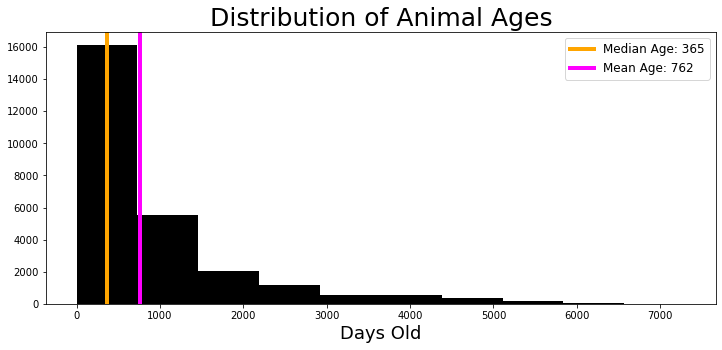

In [152]:
#https://moonbooks.org/Articles/How-to-plot-a-simple-vertical-line-on-a-matplotlib-figure-/
#https://stackoverflow.com/questions/45148704/how-to-hide-axes-and-gridlines-in-matplotlib-python
plt.figure(figsize=(12,5))
plt.title('Distribution of Animal Ages', size=25)
plt.xlabel('Days Old', size=18)
plt.axvline(x=train_med, color='orange', label=f'Median Age: {round(train_med)}', linewidth=4)
plt.axvline(x=train_mean, color='magenta', label = f'Mean Age: {round(train_mean)}', linewidth=4)
plt.legend(fontsize='12')
train['ageuponoutcome'].hist(color='black')
plt.grid(b=None);
#plt.savefig('./visualizations/ages.png', dpi=200, bbox_fit='tight');

We can clearly see that most of the animals are under 1,000 days old with a tail that gives us a right-skew overall. That's why our mean is being pulled up to 762 days (~ 2 years) but the median is only 365 days (1 year).

In [148]:
train.dtypes #one last check on data types

animalid                  object
name                      object
datetime          datetime64[ns]
outcometype               object
outcomesubtype            object
animaltype                object
sexuponoutcome            object
ageuponoutcome             int64
breed                     object
color                     object
dtype: object

In [149]:
#train.to_csv('clean_train.csv', index=False) #save clean data

In [153]:
print(train['outcometype'].value_counts(normalize=True).to_markdown())

|                 |   outcometype |
|:----------------|--------------:|
| Adoption        |    0.40353    |
| Transfer        |    0.352231   |
| Return_to_owner |    0.179301   |
| Euthanasia      |    0.0581557  |
| Died            |    0.00678233 |
